In [1]:
import os

# File paths for saving results
RESULT_DATA_DIR = os.path.join("data", "result-data")
os.makedirs(RESULT_DATA_DIR, exist_ok=True)

In [2]:
# 1. Silence logs
import os


# Set environment variables to suppress logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"                         # Only show errors from TF C++ backend
os.environ["TF_CPP_MIN_VLOG_LEVEL"] = "3"                          # Increase VLOG level to filter out debug info (try "99" if needed)
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"                          # Avoid verbose ONEDNN CPU messages
os.environ["TF_TRT_ALLOW_ENGINE_NATIVE_SEGMENT_EXECUTION"] = "false"  # Silence TF-TRT warnings
os.environ["GRPC_VERBOSITY"] = "ERROR"                           # Silence gRPC logs
os.environ["GRPC_CPP_LOG_LEVEL"] = "ERROR"


from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

# 2. Set visible GPU devices BEFORE importing TensorFlow
import sys

# Optional: Use only first GPU
USE_ONLY_GPU_INDEX = 0

# Import TensorFlow config module ONLY (not the full library yet!)
from tensorflow.python.framework import config as tf_config
from tensorflow.python.eager import context as tf_context

# List GPUs (from lower-level API)
physical_devices = tf_config.list_physical_devices('GPU')
if physical_devices:
    try:
        # Optional: use only the first GPU
        tf_config.set_visible_devices(physical_devices[USE_ONLY_GPU_INDEX], 'GPU')

        # Enable memory growth
        tf_config.set_memory_growth(physical_devices[USE_ONLY_GPU_INDEX], True)

    except RuntimeError as e:
        print("GPU config error:", e)
else:
    raise RuntimeError("❌ No GPU found!")

# 3. Now it's safe to import TensorFlow proper
import tensorflow as tf

# 4. Silence warnings if needed
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

# Optional: verify
print("GPUs available:", tf.config.list_logical_devices('GPU'))


GPUs available: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [3]:
import os
import pandas as pd

# Define the directory containing processed data files
PROCESSED_DATA = os.path.join("data", "processed-data")

# File paths for processed data
# btc_processed_file = os.path.join(PROCESSED_DATA, "btc_1min_processed.csv.gz")
# eth_processed_file = os.path.join(PROCESSED_DATA, "eth_1min_processed.csv.gz")
# combined_file = os.path.join(PROCESSED_DATA, "crypto_1min_combined.csv.gz")
# NEWS_FILTERED_CSV = os.path.join(PROCESSED_DATA, "aggregated-news_filtered.csv.gz")

# File paths for data with features
btc_features_file = os.path.join(PROCESSED_DATA, "btc_1min_with_features.csv.gz")
eth_features_file = os.path.join(PROCESSED_DATA, "eth_1min_with_features.csv.gz")

# File paths for targets
btc_target_file = os.path.join(PROCESSED_DATA, "btc_1min_targets.csv.gz")
eth_target_file = os.path.join(PROCESSED_DATA, "eth_1min_targets.csv.gz")

# Load processed data
# btc_df = pd.read_csv(btc_processed_file, compression="gzip")
# eth_df = pd.read_csv(eth_processed_file, compression="gzip")
# crypto_df = pd.read_csv(combined_file, compression="gzip")
# df_filtered_news = pd.read_csv(NEWS_FILTERED_CSV, compression="gzip")

# Load feature data
btc_df_features = pd.read_csv(btc_features_file, compression="gzip")
eth_df_features = pd.read_csv(eth_features_file, compression="gzip")

# Load target data
btc_targets = pd.read_csv(btc_target_file, compression="gzip")
eth_targets = pd.read_csv(eth_target_file, compression="gzip")


In [4]:
# %%
# Utility: Create directories
def setup_directories():
    os.makedirs("plots", exist_ok=True)
    os.makedirs("models", exist_ok=True)
    os.makedirs("logs", exist_ok=True)
    return "Done"

# %%
# Prepares merged dataset of features + targets and subsets by percentage
def get_data_subset(features_df, targets_df, target_col, data_percent=0.01):
    merged = pd.concat([features_df, targets_df], axis=1)
    subset_size = int(len(merged) * data_percent)
    subset = merged.iloc[:subset_size].copy()
    X = subset.drop(columns=[target_col])
    y = subset[target_col]
    return X, y, subset

# %%
# Normalize features using MinMaxScaler
def scale_features(X):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, scaler

# %%
# Convert time-series data into sequences
def create_sequences(X, y, time_steps=30):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i : i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# %%
# Time-based train/test split
def train_test_split_sequences(X_seq, y_seq, train_ratio=0.8):
    train_size = int(len(X_seq) * train_ratio)
    X_train, y_train = X_seq[:train_size], y_seq[:train_size]
    X_test, y_test = X_seq[train_size:], y_seq[train_size:]
    return X_train, y_train, X_test, y_test

# %%
# Build GRU model (easily replaceable with CNN/Transformer later)
def build_gru_model(input_shape):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import GRU, Dropout, Dense
    from tensorflow.keras.optimizers import Adam

    model = Sequential()
    model.add(GRU(64, activation='tanh', input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

def format_percent_string(p):
    return f"{p * 100:.4f}".rstrip("0").rstrip(".").replace(".", "_")


# %%
# Train model with checkpointing and logging
def train_model(model, X_train, y_train, X_val, y_val, data_percent=0.01, epochs=20):
    
    percent_display = format_percent_string(data_percent)

    model_name = f"gru_btc_model_{percent_display}pct.h5"
    log_name = f"gru_btc_log_{percent_display}pct.csv"

    checkpoint = ModelCheckpoint(os.path.join("models", model_name), monitor="val_loss", save_best_only=True, verbose=1)
    early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
    csv_logger = CSVLogger(os.path.join("logs", log_name))

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[checkpoint, early_stop, csv_logger],
        verbose=1
    )
    return history


# %%
# Evaluate performance
def print_metrics(y_test, y_pred, data_percent=0.01):
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    import numpy as np

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"Metrics for {data_percent*100:.3f}% dataset:")
    print(f"MSE:  {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")


In [5]:
import os
import numpy as np
import pandas as pd


In [6]:
DATA_PERCENT = 0.001
TIME_STEPS = 30
TARGET_COL = "btc_Close_1m_later"


In [7]:
setup_directories()

'Done'

In [8]:
X_raw, y_raw, btc_subset = get_data_subset(btc_df_features, btc_targets, TARGET_COL, DATA_PERCENT)


In [9]:
X_scaled, scaler = scale_features(X_raw)


In [10]:
X_seq, y_seq = create_sequences(X_scaled, y_raw.values, TIME_STEPS)

In [11]:
X_train, y_train, X_test, y_test = train_test_split_sequences(X_seq, y_seq)

In [12]:
model = build_gru_model(input_shape=(X_train.shape[1], X_train.shape[2]))

In [13]:
history = train_model(model, X_train, y_train, X_test, y_test, DATA_PERCENT)

Epoch 1/20
147/157 [===========================>..] - ETA: 0s - loss: 1.5012   
Epoch 1: val_loss improved from inf to 0.01868, saving model to models/gru_btc_model_0_1pct.h5
157/157 [==============================] - 3s 6ms/step - loss: 1.4249 - val_loss: 0.0187
Epoch 2/20
150/157 [===========================>..] - ETA: 0s - loss: 0.1781
Epoch 2: val_loss did not improve from 0.01868
157/157 [==============================] - 1s 3ms/step - loss: 0.1776 - val_loss: 0.0441
Epoch 3/20
150/157 [===========================>..] - ETA: 0s - loss: 0.1507
Epoch 3: val_loss did not improve from 0.01868
157/157 [==============================] - 1s 3ms/step - loss: 0.1497 - val_loss: 0.0223
Epoch 4/20
145/157 [==========================>...] - ETA: 0s - loss: 0.1408
Epoch 4: val_loss improved from 0.01868 to 0.00556, saving model to models/gru_btc_model_0_1pct.h5
157/157 [==============================] - 1s 4ms/step - loss: 0.1392 - val_loss: 0.0056
Epoch 5/20
145/157 [=========================

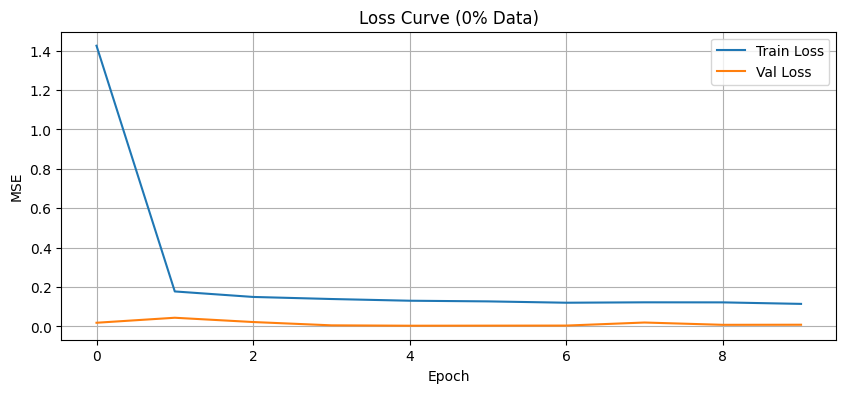

Loss curve saved to: plots/loss_curve_gru_btc_0_1pct.png


In [14]:
def plot_loss(history, plots_dir="plots", data_percent=0.01, model_name="gru", dataset_name="btc"):
    import os
    import matplotlib.pyplot as plt

    # Ensure directory exists
    os.makedirs(plots_dir, exist_ok=True)

    # Format percent strings
    percent_display_filename = format_percent_string(data_percent)  # for file name
    percent_display_title = str(int(data_percent * 100))            # for title

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"Loss Curve ({percent_display_title}% Data)")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)

    # Save to file inside plots directory
    filename = f"loss_curve_{model_name}_{dataset_name}_{percent_display_filename}pct.png"
    loss_curve_path = os.path.join(plots_dir, filename)
    plt.savefig(loss_curve_path)
    plt.show()
    print(f"Loss curve saved to: {loss_curve_path}")

plot_loss(history, data_percent=DATA_PERCENT, model_name="gru", dataset_name="btc")

In [15]:
y_pred = model.predict(X_test)

40/40 [==============================] - 0s 1ms/step


Prediction plot saved to: plots/prediction_plot_gru_btc_0_1pct.png


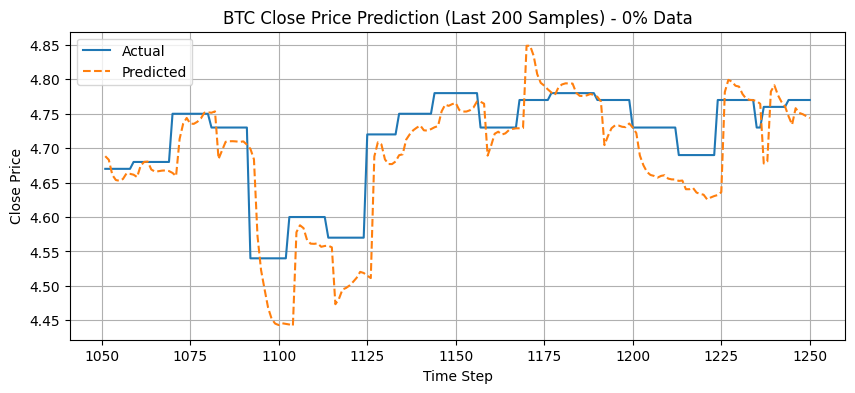

Comparison CSV saved to: data/result-data/btc_comparison_0_1pct.csv


In [16]:
def plot_predictions(y_test, y_pred, plots_dir="plots", data_percent=0.01, model_name="gru", dataset_name="btc", last_n=200):
    import os
    import matplotlib.pyplot as plt
    import pandas as pd

    # Ensure plots directory exists
    os.makedirs(plots_dir, exist_ok=True)

    # Format percent strings
    percent_display_filename = format_percent_string(data_percent)  # for file name
    percent_display_title = str(int(data_percent * 100))            # for plot title

    # Build comparison DataFrame
    comparison_df = pd.DataFrame({
        "Actual": y_test,
        "Predicted": y_pred.flatten()
    })

    # Plot predictions
    plt.figure(figsize=(10, 4))
    plt.plot(comparison_df["Actual"][-last_n:], label="Actual")
    plt.plot(comparison_df["Predicted"][-last_n:], label="Predicted", linestyle="--")
    plt.title(f"{dataset_name.upper()} Close Price Prediction (Last {last_n} Samples) - {percent_display_title}% Data")
    plt.xlabel("Time Step")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)

    # Save plot
    filename = f"prediction_plot_{model_name}_{dataset_name}_{percent_display_filename}pct.png"
    plot_path = os.path.join(plots_dir, filename)
    plt.savefig(plot_path)
    print(f"Prediction plot saved to: {plot_path}")
    plt.show()

    # Save DataFrame comparison to CSV
    result_file = os.path.join(RESULT_DATA_DIR, f"{dataset_name}_comparison_{percent_display_filename}pct.csv")
    comparison_df.to_csv(result_file, index=False)

    print(f"Comparison CSV saved to: {result_file}")
    return comparison_df


comparison_df = plot_predictions(y_test, y_pred, data_percent=DATA_PERCENT, model_name="gru", dataset_name="btc")


In [17]:
print_metrics(y_test, y_pred, DATA_PERCENT)

Metrics for 0.100% dataset:
MSE:  0.0036
RMSE: 0.0602
MAE:  0.0409


In [18]:
import os
from joblib import dump
from tensorflow.keras.models import save_model
from pathlib import Path

def save_model_and_scaler(model, scaler, model_name: str, dataset_name: str, data_percent: float, model_ext: str = "h5"):
    os.makedirs("models", exist_ok=True)

    # Format percent with up to 4 decimal places, replace dot with underscore
    percent_str = f"{data_percent * 100:.4f}".rstrip("0").rstrip(".").replace(".", "_")

    model_filename = f"{model_name}_{dataset_name}_model_{percent_str}pct.{model_ext}"
    scaler_filename = f"scaler_{dataset_name}_{percent_str}pct.pkl"

    model_path = Path("models") / model_filename
    scaler_path = Path("models") / scaler_filename

    if model_ext in ['h5', 'keras']:
        save_model(model, str(model_path))
    else:
        dump(model, model_path)

    dump(scaler, scaler_path)

    print("Model saved to:", model_path.resolve().relative_to(Path.cwd()))
    print("Scaler saved to:", scaler_path.resolve().relative_to(Path.cwd()))


In [19]:
save_model_and_scaler(model, scaler, model_name="gru", dataset_name="btc", data_percent=DATA_PERCENT)

Model saved to: models/gru_btc_model_0_1pct.h5
Scaler saved to: models/scaler_btc_0_1pct.pkl


In [20]:
import os
from joblib import load
from tensorflow.keras.models import load_model
from pathlib import Path

def load_model_and_scaler(model_name: str, dataset_name: str, data_percent: float, model_ext: str = "h5"):
    # Format percent with full decimals and replace '.' with '_'
    percent_str = f"{data_percent * 100:.4f}".rstrip("0").rstrip(".").replace(".", "_")

    model_filename = f"{model_name}_{dataset_name}_model_{percent_str}pct.{model_ext}"
    scaler_filename = f"scaler_{dataset_name}_{percent_str}pct.pkl"

    model_path = Path("models") / model_filename
    scaler_path = Path("models") / scaler_filename

    if model_ext in ['h5', 'keras']:
        model = load_model(model_path)
    else:
        model = load(model_path)

    scaler = load(scaler_path)

    print("Model loaded from:", model_path.resolve().relative_to(Path.cwd()))
    print("Scaler loaded from:", scaler_path.resolve().relative_to(Path.cwd()))

    return model, scaler

In [21]:
model, scaler = load_model_and_scaler(model_name="gru", dataset_name="btc", data_percent=DATA_PERCENT)

Model loaded from: models/gru_btc_model_0_1pct.h5
Scaler loaded from: models/scaler_btc_0_1pct.pkl


In [51]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
from backtesting import Backtest, Strategy
from bokeh.io import show, output_notebook, save

output_notebook()

def prepare_backtest_data(y_test, y_pred, time_index):
    df = pd.DataFrame({
        "Open": np.array(y_test).flatten(),
        "High": np.array(y_test).flatten(),
        "Low": np.array(y_test).flatten(),
        "Close": np.array(y_test).flatten(),
        "Signal": np.where(np.array(y_pred).flatten() > np.array(y_test).flatten(), 1, -1)
    })
    df.index = time_index
    return df

class MLStrategy(Strategy):
    def init(self):
        self.signal = self.data.Signal
    def next(self):
        if self.signal[-1] == 1:
            if not self.position.is_long:
                self.position.close()
                self.buy()
        elif self.signal[-1] == -1:
            if not self.position.is_short:
                self.position.close()
                self.sell()

def run_backtest(y_test, y_pred, initial_cash=100, model_name="gru", dataset_name="btc", data_percent=0.01):
    # Use the index from y_test if available; otherwise, create a default one.
    time_index = y_test.index if hasattr(y_test, 'index') else pd.date_range(
        start='2022-01-01', periods=len(np.array(y_test).flatten()), freq='T')
    
    data = prepare_backtest_data(y_test, y_pred, time_index)
    bt = Backtest(data, MLStrategy, cash=initial_cash, commission=0.0, exclusive_orders=True)
    stats = bt.run()
    print(stats)
    
    # Create a results directory based on model info.
    percent_str = f"{data_percent*100:.4f}".rstrip("0").rstrip(".").replace(".", "_")
    result_dir = os.path.join("results", f"{model_name}_{dataset_name}_{percent_str}pct")
    os.makedirs(result_dir, exist_ok=True)
    
    # Save backtest statistics as CSV.
    csv_filename = os.path.join(result_dir, "backtest_result.csv")
    stats.to_csv(csv_filename)
    
    # Generate the plot, save it as HTML, and display it in Jupyter.
    plot_obj = bt.plot()
    html_filename = os.path.join(result_dir, "backtest_plot.html")
    save(plot_obj, filename=html_filename)    
    return stats

# Example usage:
stats = run_backtest(y_test, y_pred, initial_cash=100, model_name="gru", dataset_name="btc", data_percent=DATA_PERCENT)


Loading BokehJS ...

Backtest.run:   0%|          | 0/1250 [00:00<?, ?bar/s]

Start                     2022-01-01 00:00:00
End                       2022-01-01 20:50:00
Duration                      0 days 20:50:00
Exposure Time [%]                         0.0
Equity Final [$]                       110.98
Equity Peak [$]                        115.12
Return [%]                              10.98
Buy & Hold Return [%]               -11.33829
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
CAGR [%]                  1058035078373143...
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Alpha [%]                              1.7785
Beta                                 -0.81154
Max. Drawdown [%]                     -5.9166
Avg. Drawdown [%]                    -2.58323
Max. Drawdown Duration        0 days 02:28:00
Avg. Drawdown Duration        0 days 00:49:00
# Trades                                    0
Win Rate [%]                      